# get-rank-plots
8.23.24

In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
from Bio import SeqIO
from scipy import stats
from adjustText import adjust_text

import matplotlib.pyplot as plt
import seaborn as sns

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette("tab10")

#### Configs

In [63]:
# The unimputed joint quants matrix
joint_fname="/net/noble/vol2/home/lincolnh/data/quant-data/UMich-normalized/joint-quants-normalized-shifted.csv"
min_pres=18

# The Lupine recon matrix
lupine_recon_ensembled_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-05-30_DE_sandbox/results/lupine-ensemble-imputed.csv"

# The Ensemble (GENCODEv44) fasta
ensembl_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2023-11-13_UMich_dataset/fastas/"
ensembl_df="gencode.v44.pc_translations.fa"

# The HGNC database file
hgnc_database_path="/net/noble/vol2/home/lincolnh/data/quant-data/HGNC_database.txt"

# The metadata dictionary, previously created
meta_path="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-05-10_metadata_mapping/meta-dict.csv"

cohort_ids=["BRCA", "CCRCC", "COAD", "GBM", "HGSC", 
            "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]

# Set the thresholds
adjusted_alpha=1e-2
fc_thresh=0.5
pres_frac_thresh=0.5 # Default here is 50%

curr_cohort = "UCEC"

rng = np.random.default_rng(seed=18)

#### Functions

In [64]:
def random_draw_impute(vec):
    """
    Imputes for a single *column* at a time using the Gaussian
    random draw procedure. This closely resembles the Perseus
    procedure described here: 
    https://cox-labs.github.io/coxdocs/replacemissingfromgaussian.html
    
    Parameters
    ----------
    vec : np.array, 
        A 1D vector, that is, column from the matrix
        to be imputed. 

    Returns
    ----------
    vec_recon : np.array, 
        The imputed vector
    """
    width_param=0.3
    downshift_param=1.8
    #print(len(vec))
    
    # Get the means and std
    v_mean = np.nanmean(vec)
    v_std = np.nanstd(vec)
    
    # Get the locations of the MVs
    nans = np.isnan(vec)
    vec_recon = vec.copy()
    
    # How many total MVs? 
    n_mv = np.count_nonzero(nans)
    
    center = v_mean - (v_std * downshift_param)

    # Replace missing values with random draws
    vec_recon[nans] = rng.normal(
                        loc=center,
                        scale=v_std*width_param,
                        size=n_mv
    )
    # Make sure we don't have any negative values
    vec_recon = np.abs(vec_recon)
    
    return vec_recon
    
def bh_adjustment(pvals):
    """
    Performs the Benjamini-Hochberg procedure
    for p-value ADJUSTMENT. So this means we actually 
    return a list of corrected p-values, not just a 
    boolean specifying which p-values to keep per the
    FDR controlled at some threshold. 
    
    Parameters
    ----------
    pvals : np.ndarray, 
        The sorted list of uncorrected p-values. Sorted
        from smallest to largest

    Returns
    -----------
    pvals_adjusted : list, 
        A list of the BH adjusted p-values
    """
    pvals_adjusted = []

    for i in range(0, len(pvals)):
        rank = i + 1
        curr_pval = pvals[i]
        pval_adj = (curr_pval * len(pvals)) / rank
        pvals_adjusted.append(pval_adj)        

    return pvals_adjusted

def add_hgnc_ids(df, d):
    """
    Our protein quants matrices have Ensemble (ENSP) IDs. We
    need to map on HGNC IDs to the differential expression stats
    dataframes. 
    
    Parameters
    ----------
    df : pandas.DataFrame,
        A dataframe with differential expression statistics for a 
        single imputation method
    d : dict, 
        A dictionary mapping ENSPs to HGNC IDs

    Returns
    ----------
    df : pandas.DataFrame, 
        The ammended dataframe.     
    """
    for idx in range(0, df.shape[0]):
        curr = df.iloc[idx]
        curr_ensp = curr["ENSP"]
        try:
            curr_ensg = d[curr_ensp]
        except KeyError:
            curr_ensg = None
    
        # Add the ENSG ID
        df.loc[idx, "ENSG"] = curr_ensg
    
        # Add in the HGNC gene ID as well 
        if curr_ensg is not None:
            try:
                hgnc_row = hgnc_db[hgnc_db["ensembl_gene_id"] == curr_ensg]
                hgnc_id = hgnc_row["symbol"].item()
    
                df.loc[idx, "HGNC"] = hgnc_id
            except ValueError:
                pass

    return df

#### Subset metadata to a single cohort, get tumor and nontumor IDs

In [65]:
# Might need `index_col=0` here
meta_dict = pd.read_csv(meta_path)
meta_dict = meta_dict[meta_dict["cohort"] == curr_cohort]
meta_dict = meta_dict.reset_index(drop=True)

tumor_samples_meta = meta_dict[(meta_dict["sample_type"] == "Primary Tumor") | (meta_dict["sample_type"] == "Tumor")]
nontumor_samples_meta = meta_dict[(meta_dict["sample_type"] != "Primary Tumor") & (meta_dict["sample_type"] != "Tumor")]

tumor_IDs = list(tumor_samples_meta["aliquot_ID"])
nontumor_IDs = list(nontumor_samples_meta["aliquot_ID"])

print(len(tumor_IDs))
print(len(nontumor_IDs))

104
31


#### Pre-process the unimputed joint quants matrix

In [66]:
# Read in the joint quants matrix
joint_mat = pd.read_csv(joint_fname, index_col=0)

# Remove some of these extraneous runs
keywords = ["RefInt", "QC", "pool", "Tumor", "Pooled", 
            "Pool", "Reference", "NCI", "NX", "Ref"]
to_drop = []

for sample_id in list(joint_mat.columns):
    exclude=False
    for kw in keywords:
        if kw in sample_id:
            exclude=True
            break
    to_drop.append(exclude)

keep_cols = np.array(joint_mat.columns)[~np.array(to_drop)]
joint_mat = joint_mat[keep_cols]

joint = np.array(joint_mat)

# Remove proteins with too many missing values
num_present = np.sum(~np.isnan(joint), axis=1)
discard = num_present < min_pres
joint = np.delete(joint, discard, axis=0)
keep_prots = np.array(joint_mat.index)[~discard]

print(f"joint quants mat shape, post-filter: {joint.shape}")

joint_start = pd.DataFrame(joint, columns=keep_cols, index=keep_prots)

joint quants mat shape, post-filter: (18162, 1755)


#### Remove proteins with >50% missingness

In [67]:
cohort_quants_start = joint_start[tumor_IDs + nontumor_IDs]

num_present = np.sum(~np.isnan(cohort_quants_start), axis=1)
pres_fracs = num_present / cohort_quants_start.shape[1]

cohort_quants_start = cohort_quants_start[pres_fracs >= pres_frac_thresh]
print(cohort_quants_start.shape)

keep_prots_cohort = list(cohort_quants_start.index)

(10108, 135)


#### Pre-process the DreamAI and Lupine imputed quants matrices

In [68]:
dream_imputed_cohort = pd.read_csv("imputed/" + curr_cohort + "_dreamAI_recon.csv", index_col=0)
unimputed_cohort = pd.read_csv("unimputed/" + curr_cohort + "_unimputed_annotated.csv", index_col=0)

dream_imputed_cohort.index = unimputed_cohort.index
dream_imputed_cohort.columns = unimputed_cohort.columns

lupine_recon = pd.read_csv(lupine_recon_ensembled_path, index_col=0)
lupine_recon = lupine_recon.loc[keep_prots_cohort]

print(dream_imputed_cohort.shape)
print(lupine_recon.shape)

(12505, 135)
(10108, 1755)


#### Exponentiate to get the original, untransformed intensities

In [69]:
joint_start = np.power(2, joint_start)
lupine_recon = np.power(2, lupine_recon)
dream_imputed_cohort = np.power(2, dream_imputed_cohort)

#### Get imputed/unimputed quants matrices for tumor and non-tumor samples
Shapes should match up now. 

In [70]:
# Retain only the proteins with initial mv fracs <0.5
lupine_recon = lupine_recon.loc[keep_prots_cohort]
dream_imputed_cohort = dream_imputed_cohort.loc[keep_prots_cohort]
unimputed_cohort = joint_start.loc[keep_prots_cohort]

# Create separate matrices for tumor and non-tumor quants
lupine_tumor = lupine_recon[tumor_IDs]
lupine_nontumor = lupine_recon[nontumor_IDs]
dream_tumor = dream_imputed_cohort[tumor_IDs]
dream_nontumor = dream_imputed_cohort[nontumor_IDs]

# For unimputed as well 
unimputed_tumor = unimputed_cohort[tumor_IDs]
unimputed_nontumor = unimputed_cohort[nontumor_IDs]

# Convert to numpy arrays
lupine_tumor_mat = np.array(lupine_tumor)
lupine_nontumor_mat = np.array(lupine_nontumor)
dream_tumor_mat = np.array(dream_tumor)
dream_nontumor_mat = np.array(dream_nontumor)

unimputed_tumor_mat = np.array(unimputed_tumor)
unimputed_nontumor_mat = np.array(unimputed_nontumor)

print(lupine_tumor_mat.shape)
print(dream_tumor_mat.shape)
print(unimputed_tumor_mat.shape)
print("")

print(lupine_nontumor_mat.shape)
print(dream_nontumor_mat.shape)
print(unimputed_nontumor_mat.shape)

(10108, 104)
(10108, 104)
(10108, 104)

(10108, 31)
(10108, 31)
(10108, 31)


#### Apply Gaussian random sampling imputation 

In [71]:
grs_tumor_mat = np.apply_along_axis(random_draw_impute, 0, unimputed_tumor_mat)
grs_nontumor_mat = np.apply_along_axis(random_draw_impute, 0, unimputed_nontumor_mat)

#### DE testing for Lupine imputed quants

In [72]:
lupine_pvals = []
lupine_rs_stats = []

for i in range(0, lupine_tumor_mat.shape[0]):
    stat, pval = stats.ranksums(lupine_tumor_mat[i], lupine_nontumor_mat[i], nan_policy="omit")
    lupine_pvals.append(pval)
    lupine_rs_stats.append(stat)

# Init a dataframe to hold the p-values and adjusted p-values
lupine_stats = pd.DataFrame(columns = ["ENSP", "pval", "adj_pval", "orig_idx"])
lupine_stats["ENSP"] = list(lupine_tumor.index)
lupine_stats["pval"] = lupine_pvals

#### DE testing for DreamAI imputed quants

In [73]:
dream_pvals = []
dream_rs_stats = []

for i in range(0, dream_tumor_mat.shape[0]):
    stat, pval = stats.ranksums(dream_tumor_mat[i], dream_nontumor_mat[i], nan_policy="omit")
    dream_pvals.append(pval)
    dream_rs_stats.append(stat)

# Init a dataframe to hold the p-values and adjusted p-values
dream_stats = pd.DataFrame(columns = ["ENSP", "pval", "adj_pval", "orig_idx"])
dream_stats["ENSP"] = list(dream_tumor.index)
dream_stats["pval"] = dream_pvals

#### DE testing for Gaussian random sampling imputed quants

In [74]:
grs_pvals = []
grs_rs_stats = []

for i in range(0, grs_tumor_mat.shape[0]):
    stat, pval = stats.ranksums(grs_tumor_mat[i], grs_nontumor_mat[i], nan_policy="omit")
    grs_pvals.append(pval)
    grs_rs_stats.append(stat)

# Init a dataframe to hold the p-values and adjusted p-values
grs_stats = pd.DataFrame(columns = ["ENSP", "pval", "adj_pval", "orig_idx"])
grs_stats["ENSP"] = list(unimputed_tumor.index)
grs_stats["pval"] = grs_pvals

#### Do Benjamani-Hochberg correction for Lupine imputed quants

In [75]:
# Sort by uncorrected p-values
lupine_stats = lupine_stats.sort_values(by="pval")
# Do the BH adjustment
lupine_pvals_corrected = bh_adjustment(np.array(lupine_stats["pval"]))
lupine_stats["adj_pval"] = lupine_pvals_corrected
lupine_stats["orig_idx"] = list(lupine_stats.index)

# Return to the initial order
lupine_stats = lupine_stats.sort_values(by="orig_idx")

#### And BH correction for DreamAI imputed quants

In [76]:
# Sort by uncorrected p-values
dream_stats = dream_stats.sort_values(by="pval")
# Do the BH adjustment
dream_pvals_corrected = bh_adjustment(np.array(dream_stats["pval"]))
dream_stats["adj_pval"] = dream_pvals_corrected
dream_stats["orig_idx"] = list(dream_stats.index)

# Return to the initial order
dream_stats = dream_stats.sort_values(by="orig_idx")

#### And BH correction for Gaussian random sample imputed quants

In [77]:
# Sort by uncorrected p-values
grs_stats = grs_stats.sort_values(by="pval")
# Do the BH adjustment
grs_pvals_corrected = bh_adjustment(np.array(grs_stats["pval"]))
grs_stats["adj_pval"] = grs_pvals_corrected
grs_stats["orig_idx"] = list(grs_stats.index)

# Return to the initial order
grs_stats = grs_stats.sort_values(by="orig_idx")

#### Get the log2 fold changes for Lupine imputed quants

In [78]:
lupine_tumor_means = np.nanmean(lupine_tumor_mat, axis=1)
lupine_nontumor_means = np.nanmean(lupine_nontumor_mat, axis=1)

lupine_fc = np.log2(lupine_tumor_means / lupine_nontumor_means)

lupine_fdr = -np.log10(np.array(lupine_stats["adj_pval"]))

lupine_stats["FC"] = lupine_fc
lupine_stats["FDR"] = lupine_fdr

#### And the log2 fold changes for DreamAI

In [79]:
dream_tumor_means = np.nanmean(dream_tumor_mat, axis=1)
dream_nontumor_means = np.nanmean(dream_nontumor_mat, axis=1)

dream_fc = np.log2(dream_tumor_means / dream_nontumor_means)

dream_fdr = -np.log10(np.array(dream_stats["adj_pval"]))

dream_stats["FC"] = dream_fc
dream_stats["FDR"] = dream_fdr

#### And the log2 fold changes for Gaussian random sample

In [80]:
grs_tumor_means = np.nanmean(grs_tumor_mat, axis=1)
grs_nontumor_means = np.nanmean(grs_nontumor_mat, axis=1)

grs_fc = np.log2(grs_tumor_means / grs_nontumor_means)

grs_fdr = -np.log10(np.array(grs_stats["adj_pval"]))

grs_stats["FC"] = grs_fc
grs_stats["FDR"] = grs_fdr

#### Create a dictionary mapping ENSPs to HGNCs

In [81]:
# Read in the HGNC database file
hgnc_db = pd.read_csv(hgnc_database_path, sep="\t")

# Read in the ENSEMBL fasta
ensembl_fasta = ensembl_path + ensembl_df
fasta_seqs = SeqIO.parse(open(ensembl_fasta), "fasta")

# Init both dictionaries
gene_x_prot = {}
prot_x_gene = {}

# Fill in the dictionary 
for fasta in fasta_seqs:
    name, descript, sequence = \
        fasta.id, fasta.description, str(fasta.seq)
    # Get the ENSP and ENSG IDs
    ensp_id = name.split("|")[0]
    ensg_id = name.split("|")[2]
    # Strip the ".x" characters. Hope this is ok.
    ensp_id = ensp_id.split(".")[0]
    ensg_id = ensg_id.split(".")[0]
    
    # Update the first dictionary
    prot_x_gene[ensp_id] = ensg_id
    
    # Update the second
    if ensg_id in gene_x_prot:
        gene_x_prot[ensg_id].append(ensp_id)
    else:
        gene_x_prot[ensg_id] = [ensp_id]

/tmp/ipykernel_2227498/1917651185.py:2: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  hgnc_db = pd.read_csv(hgnc_database_path, sep="\t")


#### Append the HGNC IDs to each method's stats dataframe

In [82]:
lupine_stats = add_hgnc_ids(lupine_stats, prot_x_gene)
dream_stats = add_hgnc_ids(dream_stats, prot_x_gene)
grs_stats = add_hgnc_ids(grs_stats, prot_x_gene)

#### Log2 transform the protein intensities?
Should probably do this before computing the means. 

In [83]:
lupine_tumor_mat = np.log2(lupine_tumor_mat)
lupine_nontumor_mat = np.log2(lupine_nontumor_mat)

dream_tumor_mat = np.log2(dream_tumor_mat)
dream_nontumor_mat = np.log2(dream_nontumor_mat)

grs_tumor_mat = np.log2(grs_tumor_mat)
grs_nontumor_mat = np.log2(grs_nontumor_mat)

#### Get tumor/non-tumor protein mean intensities, for all three methods

In [84]:
# FOR LUPINE
lupine_tumor_means = np.mean(lupine_tumor_mat, axis=1)
lupine_nontumor_means = np.mean(lupine_nontumor_mat, axis=1)

lupine_stats["tumor_means"] = list(lupine_tumor_means)
lupine_stats["nontumor_means"] = list(lupine_nontumor_means)

# FOR DREAM
dream_tumor_means = np.mean(dream_tumor_mat, axis=1)
dream_nontumor_means = np.mean(dream_nontumor_mat, axis=1)

dream_stats["tumor_means"] = list(dream_tumor_means)
dream_stats["nontumor_means"] = list(dream_nontumor_means)

# FOR GAUSSIAN RANDOM SAMPLE 
grs_tumor_means = np.mean(grs_tumor_mat, axis=1)
grs_nontumor_means = np.mean(grs_nontumor_mat, axis=1)

grs_stats["tumor_means"] = list(grs_tumor_means)
grs_stats["nontumor_means"] = list(grs_nontumor_means)

#### Sort, then attach y-coordinates
Just for the Lupine matrix

In [85]:
lupine_stats = lupine_stats.sort_values(by="nontumor_means")
y_coords = list(range(0, lupine_stats.shape[0], 1))
y_coords.reverse()
lupine_stats["y_coord"] = y_coords

#### Get the most basic rank plot
For Lupine imputed quants

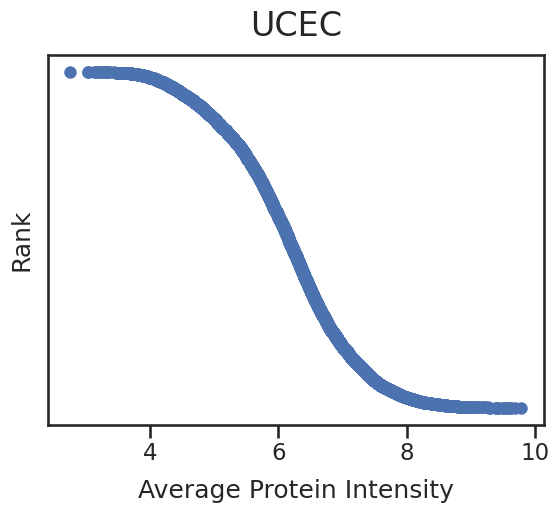

In [86]:
plt.figure()

sns.scatterplot(data=lupine_stats, x="nontumor_means", y="y_coord", alpha=1.0, linewidth=0.0)

plt.xlabel("Average Protein Intensity", labelpad=10)
plt.ylabel("Rank", labelpad=10)
plt.title(curr_cohort, pad=14, size=24)

plt.yticks([], [])

plt.show()

---
## Now map on the Lupine-unique DE proteins

#### Start by getting the up-and down-regulated proteins for each method

In [87]:
# FOR LUPINE
lupine_up_reg = lupine_stats[(lupine_stats["adj_pval"] < adjusted_alpha) & \
                    (lupine_stats["FC"] >= fc_thresh)]
lupine_down_reg = lupine_stats[(lupine_stats["adj_pval"] < adjusted_alpha) & \
                    (lupine_stats["FC"] <= -fc_thresh)]

# FOR DREAM
dream_up_reg = dream_stats[(dream_stats["adj_pval"] < adjusted_alpha) & \
                    (dream_stats["FC"] >= fc_thresh)]
dream_down_reg = dream_stats[(dream_stats["adj_pval"] < adjusted_alpha) & \
                    (dream_stats["FC"] <= -fc_thresh)]

# FOR GAUSSIAN RANDOM SAMPLE 
grs_up_reg = grs_stats[(grs_stats["adj_pval"] < adjusted_alpha) & \
                    (grs_stats["FC"] >= fc_thresh)]
grs_down_reg = grs_stats[(grs_stats["adj_pval"] < adjusted_alpha) & \
                    (grs_stats["FC"] <= -fc_thresh)]

print(f"Lupine up-reg: {lupine_up_reg.shape[0]}")
print(f"Lupine down-reg: {lupine_down_reg.shape[0]}\n")

print(f"Dream up-reg: {dream_up_reg.shape[0]}")
print(f"Dream down-reg: {dream_down_reg.shape[0]}\n")

print(f"Gaussian random sample up-reg: {dream_up_reg.shape[0]}")
print(f"Gaussian random sample down-reg: {dream_down_reg.shape[0]}")

Lupine up-reg: 33
Lupine down-reg: 344

Dream up-reg: 29
Dream down-reg: 334

Gaussian random sample up-reg: 29
Gaussian random sample down-reg: 334


#### Get the intersections between Lupine and Dream

In [88]:
lupine_up_ids = list(lupine_up_reg["HGNC"])
lupine_down_ids = list(lupine_down_reg["HGNC"])

dream_up_ids = list(dream_up_reg["HGNC"])
dream_down_ids = list(dream_down_reg["HGNC"])

up_reg_inter = set(np.intersect1d(lupine_up_ids, dream_up_ids))
down_reg_inter = set(np.intersect1d(lupine_down_ids, dream_down_ids))

# This (hopefully?) takes care of the NaNs
#up_reg_inter = list(up_reg_inter)[:-1]
#down_reg_inter = list(down_reg_inter)[:-1]

lupine_only_up = list(set(lupine_up_ids) - set(up_reg_inter))
lupine_only_down = list(set(lupine_down_ids) - set(down_reg_inter))

print(f"Up-reg intersection: {len(up_reg_inter)}")
print(f"Up-reg Lupine unique: {len(lupine_only_up)}\n")

print(f"Down-reg intersection: {len(down_reg_inter)}")
print(f"Down-reg Lupine unique: {len(lupine_only_down)}")

Up-reg intersection: 27
Up-reg Lupine unique: 5

Down-reg intersection: 301
Down-reg Lupine unique: 15


#### And also the intersections between Lupine and Gaussian random sample impute

In [89]:
grs_up_ids = list(grs_up_reg["HGNC"])
grs_down_ids = list(grs_down_reg["HGNC"])

exclude_up = np.intersect1d(grs_up_ids, lupine_only_up)
exclude_down = np.intersect1d(grs_down_ids, lupine_only_down)

lupine_unique_up = set(lupine_only_up) - set(exclude_up)
lupine_unique_down = set(lupine_only_down) - set(exclude_down)

# Hopefully get rid of NaNs
lupine_unique_up = list(lupine_unique_up)[1:]

print(len(lupine_unique_up))
print(len(lupine_unique_down))

print(lupine_unique_up)

4
8
['AKAP6', 'CXCL17', 'KNL1', 'HOXB4']


#### Get a separate stats dataframe for the Lupine unique proteins

In [90]:
unique_idx = lupine_stats["HGNC"].isin(lupine_unique_up)
lupine_stats_unique = lupine_stats[unique_idx]

#### And plot again 

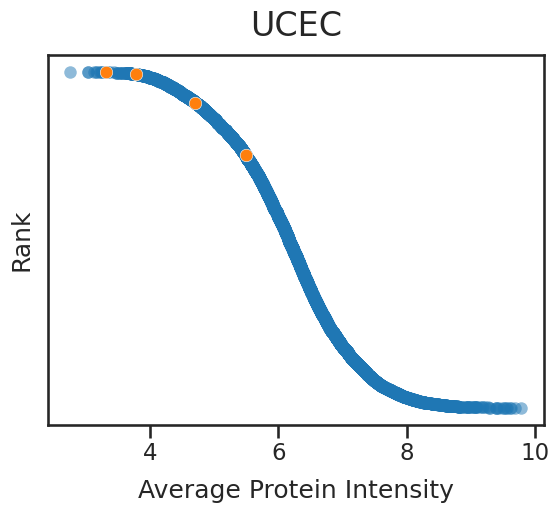

In [91]:
plt.figure()

sns.scatterplot(
    data=lupine_stats, 
    x="nontumor_means", 
    y="y_coord", 
    alpha=0.5, 
    linewidth=0.0,
    color="#1f77b4",
)
sns.scatterplot(
    data=lupine_stats_unique, 
    x="nontumor_means", 
    y="y_coord", 
    alpha=1.0, 
    linewidth=0.4,
    color="#ff7f0e"
)

plt.xlabel("Average Protein Intensity", labelpad=10)
plt.ylabel("Rank", labelpad=10)
plt.title(curr_cohort, pad=14, size=24)

plt.yticks([], [])

plt.show()

#### Do this for all three cohorts? 
Is there a less hacky way to do this? 

In [92]:
# lupine_stats_PDAC = lupine_stats
# lupine_stats_unique_PDAC = lupine_stats_unique

# lupine_stats_CCRCC = lupine_stats
# lupine_stats_unique_CCRCC = lupine_stats_unique

lupine_stats_UCEC = lupine_stats
lupine_stats_unique_UCEC = lupine_stats_unique

#### Get three-way plot

/tmp/ipykernel_2227498/2221635751.py:85: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg3.legendHandles:


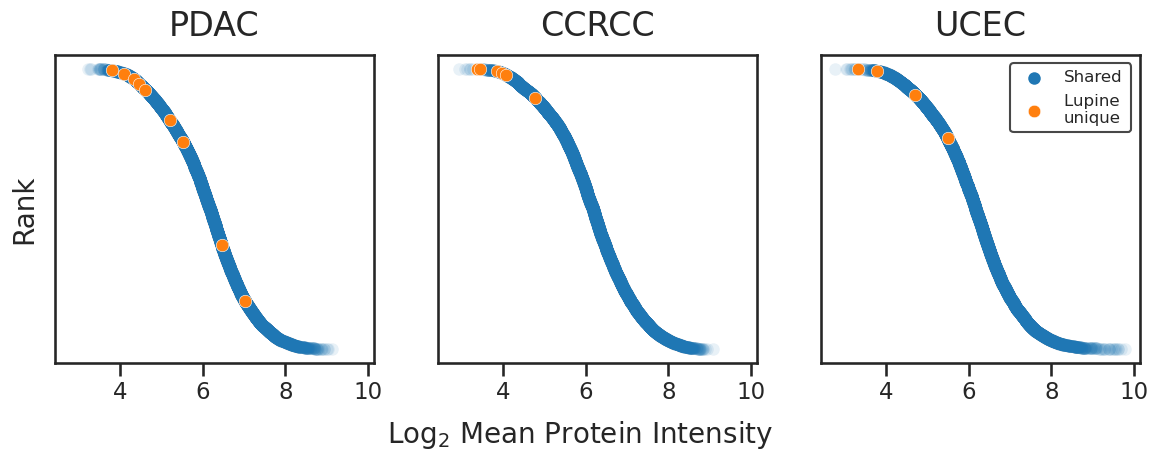

In [93]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4), sharex=True)

# # THE FIRST COHORT -- PDAC
# sns.scatterplot(
#     data=lupine_stats_PDAC, 
#     x="nontumor_means", 
#     y="y_coord", 
#     alpha=0.1, 
#     linewidth=0.0,
#     color="#1f77b4",
#     ax=ax1
# )
# sns.scatterplot(
#     data=lupine_stats_unique_PDAC, 
#     x="nontumor_means", 
#     y="y_coord", 
#     alpha=1.0, 
#     linewidth=0.4,
#     color="#ff7f0e",
#     ax=ax1
# )
# ax1.set_yticks([], [])
# ax1.set_title("PDAC", pad=14, size=24)
# ax1.set_xlabel("")
# ax1.set_ylabel("Rank", labelpad=12, size=20)

# # THE SECOND COHORT -- CCRCC
# sns.scatterplot(
#     data=lupine_stats_CCRCC, 
#     x="nontumor_means", 
#     y="y_coord", 
#     alpha=0.1, 
#     linewidth=0.0,
#     color="#1f77b4",
#     ax=ax2,
# )
# sns.scatterplot(
#     data=lupine_stats_unique_CCRCC, 
#     x="nontumor_means", 
#     y="y_coord", 
#     alpha=1.0, 
#     linewidth=0.4,
#     color="#ff7f0e",
#     ax=ax2,
# )
# ax2.set_yticks([], [])
# ax2.set_title("CCRCC", pad=14, size=24)
# ax2.set_xlabel("")
# ax2.set_ylabel("")

# # THE THIRD COHORT -- UCEC
# sns.scatterplot(
#     data=lupine_stats_UCEC, 
#     x="nontumor_means", 
#     y="y_coord", 
#     alpha=0.1, 
#     linewidth=0.0,
#     color="#1f77b4",
#     ax=ax3,
# )
# sns.scatterplot(
#     data=lupine_stats_unique_UCEC, 
#     x="nontumor_means", 
#     y="y_coord", 
#     alpha=1.0, 
#     linewidth=0.4,
#     color="#ff7f0e",
#     ax=ax3,
# )
# ax3.set_yticks([], [])
# ax3.set_title("UCEC", pad=14, size=24)
# ax3.set_xlabel("")
# ax3.set_ylabel("")

# fig.text(0.5, -0.09, "Log$_{2}$ Mean Protein Intensity", ha='center', size=20)

# leg3 = ax3.legend(
#             title="", 
#             edgecolor="k", 
#             fancybox=True,
#             prop={'size': 12}, 
#             bbox_to_anchor=(1.0, 1.0),
#             labels=["Shared", "Lupine \nunique"],
# )
# for lh in leg3.legendHandles:
#     lh.set_alpha(1)

# plt.show()
# #plt.savefig("../figures/lupine-DE-rankplots.pdf", bbox_inches="tight")

#### What if we tried to add the names of the proteins? 
This one looks really good. 

/tmp/ipykernel_2227498/1574073558.py:121: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg3.legendHandles:


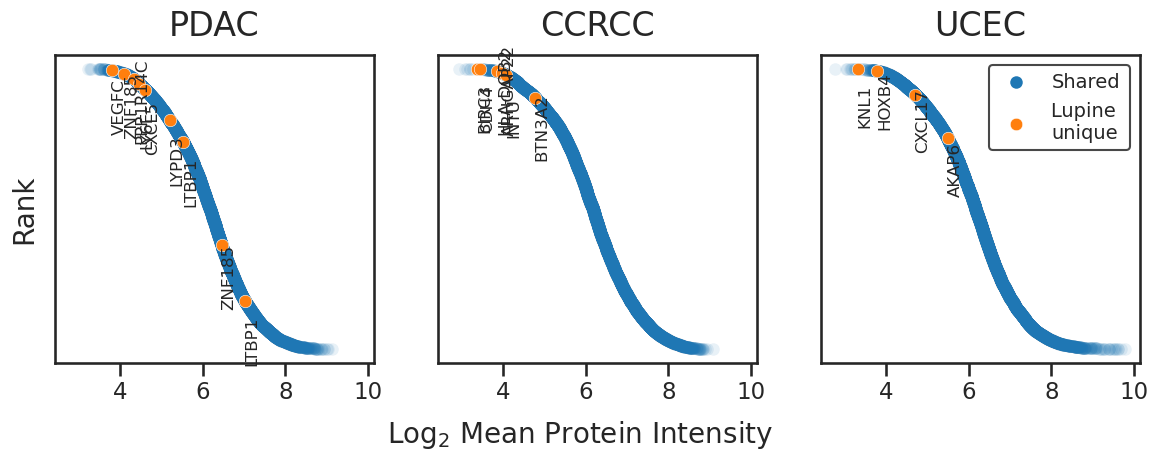

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4), sharex=True)

# THE FIRST COHORT -- PDAC
sns.scatterplot(
    data=lupine_stats_PDAC, 
    x="nontumor_means", 
    y="y_coord", 
    alpha=0.1, 
    linewidth=0.0,
    color="#1f77b4",
    ax=ax1
)
sns.scatterplot(
    data=lupine_stats_unique_PDAC, 
    x="nontumor_means", 
    y="y_coord", 
    alpha=1.0, 
    linewidth=0.4,
    color="#ff7f0e",
    ax=ax1
)
ax1.set_yticks([], [])
ax1.set_title("PDAC", pad=14, size=24)
ax1.set_xlabel("")
ax1.set_ylabel("Rank", labelpad=12, size=20)

# Annotate the gene IDs
for idx, row in lupine_stats_unique_PDAC.iterrows():
    x_coord = row["nontumor_means"]
    y_coord = row["y_coord"]
    ax1.annotate(
        text=row["HGNC"],
        xy=(x_coord, y_coord), 
        xytext=(x_coord, y_coord-2000),
        fontsize=12, 
        rotation=90,
    )

# THE SECOND COHORT -- CCRCC
sns.scatterplot(
    data=lupine_stats_CCRCC, 
    x="nontumor_means", 
    y="y_coord", 
    alpha=0.1, 
    linewidth=0.0,
    color="#1f77b4",
    ax=ax2,
)
sns.scatterplot(
    data=lupine_stats_unique_CCRCC, 
    x="nontumor_means", 
    y="y_coord", 
    alpha=1.0, 
    linewidth=0.4,
    color="#ff7f0e",
    ax=ax2,
)
ax2.set_yticks([], [])
ax2.set_title("CCRCC", pad=14, size=24)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Annotate the gene IDs
for idx, row in lupine_stats_unique_CCRCC.iterrows():
    x_coord = row["nontumor_means"]
    y_coord = row["y_coord"]
    ax2.annotate(
        text=row["HGNC"],
        xy=(x_coord, y_coord), 
        xytext=(x_coord, y_coord-2000),
        fontsize=12, 
        rotation=90,
    )

# THE THIRD COHORT -- UCEC
sns.scatterplot(
    data=lupine_stats_UCEC, 
    x="nontumor_means", 
    y="y_coord", 
    alpha=0.1, 
    linewidth=0.0,
    color="#1f77b4",
    ax=ax3,
)
sns.scatterplot(
    data=lupine_stats_unique_UCEC, 
    x="nontumor_means", 
    y="y_coord", 
    alpha=1.0, 
    linewidth=0.4,
    color="#ff7f0e",
    ax=ax3,
)
ax3.set_yticks([], [])
ax3.set_title("UCEC", pad=14, size=24)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Annotate the gene IDs
for idx, row in lupine_stats_unique_UCEC.iterrows():
    x_coord = row["nontumor_means"]
    y_coord = row["y_coord"]
    ax3.annotate(
        text=row["HGNC"],
        xy=(x_coord, y_coord), 
        xytext=(x_coord, y_coord-2000),
        fontsize=12, 
        rotation=90,
    )

fig.text(0.5, -0.09, "Log$_{2}$ Mean Protein Intensity", ha='center', size=20)

leg3 = ax3.legend(
            title="", 
            edgecolor="k", 
            fancybox=True,
            prop={'size': 14}, 
            bbox_to_anchor=(1.0, 1.0),
            labels=["Shared", "Lupine \nunique"],
)
for lh in leg3.legendHandles:
    lh.set_alpha(1)

plt.show()
#plt.savefig("../figures/lupine-DE-rankplots.pdf", bbox_inches="tight")